In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 7.5 MB/s 


In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import sys
#import keras_tuner

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
sys.path.append('/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/')
sys.path.append('/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/NCF')
import Loader
import Metric

# 1. 학습
## 1-1. 데이터 로드

In [8]:
DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/data/preprocessed/'
loader = Loader.Loader(DIR, 2, 4)
loader.load_dataset()

(29960, 4396)

In [9]:
train = loader.formatting(0)
train_usr, train_prb, train_entry = shuffle(train[0], train[1], train[2])
train_usr = np.array(train_usr).reshape(-1,1)
train_prb = np.array(train_prb).reshape(-1,1)
train_entry = np.array(train_entry).reshape(-1,1)

In [10]:
valid_tr, valid_te  = loader.formatting(1)
valid_te_y, valid_te_X = valid_te
valid_tr_usr, valid_tr_prb, valid_tr_entry = shuffle(valid_tr[0], valid_tr[1], valid_tr[2])
valid_tr_usr = np.array(valid_tr_usr).reshape(-1,1)
valid_tr_prb = np.array(valid_tr_prb).reshape(-1,1)
valid_tr_entry = np.array(valid_tr_entry).reshape(-1,1)

In [11]:
test_tr, test_te  = loader.formatting(2)
test_te_y, test_te_X = test_te
test_tr_usr, test_tr_prb, test_tr_entry = shuffle(test_tr[0], test_tr[1], test_tr[2])
test_tr_usr = np.array(test_tr_usr).reshape(-1,1)
test_tr_prb = np.array(test_tr_prb).reshape(-1,1)
test_tr_entry = np.array(test_tr_entry).reshape(-1,1)

## 1-2. 하이퍼 파라미터 튜닝
* 잠재요인 수
* learning rate
* dropout

In [ ]:
class HyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    self.user_no = loader.users_no+5
    self.prob_no = loader.prob_no
    self.K = hp.Int('K', 2, 8, step=2, default=4)
    # input layer
    input_user = tf.keras.layers.Input(shape=(1,), dtype='int32')
    input_prob =  tf.keras.layers.Input(shape=(1,), dtype='int32')
        
    # GMF
    gmf_embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.user_no, self.K)(input_user))
    gmf_embedding_prob =  tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.prob_no, self.K)(input_prob)) 
    gmf_matmul =  tf.keras.layers.Multiply()([gmf_embedding_user, gmf_embedding_prob])

    # MLP
    mlp_embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.user_no, 32)(input_user))
    mlp_embedding_item= tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.prob_no, 32)(input_prob))
    mlp_concat = tf.keras.layers.Concatenate()([mlp_embedding_user, mlp_embedding_item])
    mlp_dropout0 = tf.keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.2))(mlp_concat)

    mlp_layer1 = tf.keras.layers.Dense(64)(mlp_dropout0)
    mlp_batch_norm1 = tf.keras.layers.BatchNormalization()(mlp_layer1)
    mlp_relu1 = tf.keras.layers.Activation('relu')(mlp_batch_norm1)
    mlp_dropout1 = tf.keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.2))(mlp_relu1)                    
              
    mlp_layer2 = tf.keras.layers.Dense(32)(mlp_dropout1)
    mlp_batch_norm2 = tf.keras.layers.BatchNormalization()(mlp_layer2)
    mlp_relu2 = tf.keras.layers.Activation('relu')(mlp_batch_norm2)
    mlp_dropout2 = tf.keras.layers.Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1, default=0.2))(mlp_relu2) 

    mlp_layer3 = tf.keras.layers.Dense(16)(mlp_dropout2)
    mlp_batch_norm3 = tf.keras.layers.BatchNormalization()(mlp_layer3)
    mlp_relu3 = tf.keras.layers.Activation('relu')(mlp_batch_norm3)
    mlp_dropout3 = tf.keras.layers.Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1, default=0.2))(mlp_relu3) 

    mlp_layer4 = tf.keras.layers.Dense(8)(mlp_dropout3)
    mlp_relu4 = tf.keras.layers.Activation('relu')(mlp_layer4)

    # GMF + MLP
    concat = tf.keras.layers.concatenate([gmf_matmul, mlp_relu4])

    # output layer
    output = tf.keras.layers.Dense(1)(concat)
    
    # model
    self.model = tf.keras.Model(inputs=[input_user, input_prob], outputs=output)
    # optimizer & loss function 설정
    self.optimizer = tf.keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3))
    self.loss_fn = tf.keras.losses.MeanSquaredError()
    self.model.compile(optimizer = self.optimizer, loss = self.loss_fn)
    return self.model 

  def fit(self, hp, model, train_data, validation_data, callbacks=None, **kwargs):
    train_N = len(train_data[0])
    valid_tr_N = len(validation_data[0])
    batch_size = 1024

    # The metric to track validation loss.
    epoch_loss_metric = tf.keras.metrics.Mean()

    # 학습
    @tf.function
    def run_train_step(train_X, train_y):
      with tf.GradientTape() as tape:
        pred = model((train_X[0], train_X[1]))
        loss = self.loss_fn(train_y, pred)
        if model.losses:
          loss += tf.math.add_n(model.losses)

      gradients = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # 검증
    @tf.function
    def run_val_step(valid_X, valid_y):
      pred = model((valid_X[0], valid_X[1]))
      loss = self.loss_fn(valid_y, pred)
      epoch_loss_metric.update_state(loss)

    # callback에 모델 할당
    for callback in callbacks:
      callback.model = model

    best_epoch_loss = float("inf")
    for epoch in range(10):
      print(f"Epoch: {epoch}")

      # 학습
      for i in range(0, train_N, batch_size):
        idxlist = range(i, min(i+batch_size, train_N-1))
        run_train_step([train_data[0][idxlist], train_data[1][idxlist]], train_data[2][idxlist])

      # 검증
      for i in range(0, valid_tr_N, batch_size):
        idxlist = range(i, min(i+batch_size, valid_tr_N-1))
        run_val_step([validation_data[0][idxlist], validation_data[1][idxlist]], validation_data[2][idxlist])

      epoch_loss = float(epoch_loss_metric.result().numpy())
      # callback에 loss epoch, 저장
      for callback in callbacks:
        callback.on_epoch_end(epoch, logs={"validation loss": epoch_loss})
      epoch_loss_metric.reset_states()

      print(f"Epoch loss: {epoch_loss}")
      best_epoch_loss = min(best_epoch_loss, epoch_loss)

    return best_epoch_loss      

In [ ]:
HP_DIR = "/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/NCF/hp_tuning"

In [ ]:
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("validation loss", "min"),
    max_trials=10,
    hypermodel=HyperModel(),
    directory=HP_DIR,
    project_name="cluster2",
    overwrite=True
)

In [ ]:
tuner.search(train_data=[train_usr, train_prb, train_entry], validation_data=[valid_tr_usr, valid_tr_prb, valid_tr_entry])

Trial 10 Complete [00h 04m 54s]
validation loss: 0.03812321275472641

Best validation loss So Far: 0.03327510133385658
Total elapsed time: 00h 49m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'K': 8, 'dropout': 0.4, 'dropout2': 0.1, 'learning_rate': 0.0002253374765329313}


##1-3. 모델

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd

class NCF:
    def __init__(self, user_no, prob_no, useridx2level, probidx2level, K=8):
        # 변수
        self.user_no = user_no+5
        self.prob_no = prob_no
        self.useridx2level = useridx2level
        self.probidx2level = probidx2level
        self.K = K

        # 레이어
        # input layer
        input_user = tf.keras.layers.Input(shape=(1,), dtype='int32') 
        input_prob =  tf.keras.layers.Input(shape=(1,), dtype='int32')
        
        # GMF
        gmf_embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.user_no, K)(input_user))
        gmf_embedding_prob =  tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.prob_no, K)(input_prob)) 
        gmf_matmul =  tf.keras.layers.Multiply()([gmf_embedding_user, gmf_embedding_prob])

        # MLP
        mlp_embedding_user = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.user_no, 32)(input_user))
        mlp_embedding_item = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(self.prob_no, 32)(input_prob))
        mlp_concat = tf.keras.layers.Concatenate()([mlp_embedding_user, mlp_embedding_item])
        mlp_dropout0 = tf.keras.layers.Dropout(0.4)(mlp_concat)

        mlp_layer1 = tf.keras.layers.Dense(64)(mlp_dropout0)
        mlp_batch_norm1 = tf.keras.layers.BatchNormalization()(mlp_layer1)
        mlp_relu1 = tf.keras.layers.Activation('relu')(mlp_batch_norm1)
        mlp_dropout1 = tf.keras.layers.Dropout(0.4)(mlp_relu1)                    
              
        mlp_layer2 = tf.keras.layers.Dense(32)(mlp_dropout1)
        mlp_batch_norm2 = tf.keras.layers.BatchNormalization()(mlp_layer2)
        mlp_relu2 = tf.keras.layers.Activation('relu')(mlp_batch_norm2)
        mlp_dropout2 = tf.keras.layers.Dropout(0.1)(mlp_relu2) 

        mlp_layer3 = tf.keras.layers.Dense(16)(mlp_dropout2)
        mlp_batch_norm3 = tf.keras.layers.BatchNormalization()(mlp_layer3)
        mlp_relu3 = tf.keras.layers.Activation('relu')(mlp_batch_norm3)
        mlp_dropout3 = tf.keras.layers.Dropout(0.1)(mlp_relu3) 

        mlp_layer4 = tf.keras.layers.Dense(8)(mlp_dropout3)
        mlp_relu4 = tf.keras.layers.Activation('relu')(mlp_layer4)

        # GMF + MLP
        concat = tf.keras.layers.concatenate([gmf_matmul, mlp_relu4])

        # output layer
        output = tf.keras.layers.Dense(1)(concat)

        # 모델
        self.model = tf.keras.Model(inputs=[input_user, input_prob], outputs=output)

    def train(self, model, train_usr, train_prb, train_entry, valid_tr_usr, valid_tr_prb, valid_tr_entry, valid_te_X, valid_te_y, cluster, epochs=100, batch_size=1024, k=30):
      train_N = len(train_usr)
      valid_tr_N = len(valid_tr_usr)
      valid_te_N = len(valid_te_X) 
      rc_vad = [] 
      hr_vad = []
      best_eval = -1
      best_epoch = -1
      BESTMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/NCF/best_model/cluster' + str(cluster)

      for epoch in range(0, epochs):
        ct, tr_loss, vad_loss = 0, 0, 0
        for i in range(0, train_N, batch_size):
          idxlist = range(i, min(i+batch_size, train_N-1))
          hist = model.fit([train_usr[idxlist], train_prb[idxlist]], train_entry[idxlist], verbose=0)
          ct+=1
          tr_loss += hist.history['loss'][-1]
        
        print("epoch[", epoch, "] train loss: ", tr_loss / ct)
        weights = model.get_weights()

        ct = 0
        for i in range(0, valid_tr_N, batch_size):
          idxlist = range(i, min(i+batch_size, valid_tr_N-1))
          hist = model.fit([valid_tr_usr[idxlist], valid_tr_prb[idxlist]], valid_tr_entry[idxlist],verbose=0)
          ct +=1
          vad_loss += hist.history['loss'][-1]
        
        print("epoch[", epoch, "] validation loss: ", vad_loss / ct)
        
        hit_rate = 0
        recall = []
        for i in range(0, valid_te_N):
          usr = valid_te_X.iloc[i,0]
          prbs = np.array(valid_te_X.iloc[i,1])
          usrs = np.array([usr]*len(prbs))
          valid_te_usr = usrs.reshape(-1,1)
          valid_te_prb = prbs.reshape(-1,1)

          pred = model.predict([valid_te_usr, valid_te_prb])
          pred = np.concatenate(pred).reshape(-1,1)
          filtered = self.level_filtering(valid_te_usr, valid_te_prb, pred, self.useridx2level, self.probidx2level, k)

          # valid_y
          heldout = np.array(valid_te_y.iloc[i,1])
          recall.append(Metric.recall_at_k(filtered[1], heldout, k))
          hit_rate += Metric.hit_rate_at_k(filtered[1], heldout, k)
          
        recall_ = np.mean(recall)
        hit_rate_ = hit_rate/valid_te_N
        print("epoch[", epoch, "] recall: ", recall_)
        print("epoch[", epoch, "] hit rate: ", hit_rate_)
        
        model.set_weights(weights)
        
        #if hit_rate_ > 0.30:
          #break

        rc_vad.append(recall_)
        hr_vad.append(hit_rate_)

        if hit_rate_ > best_eval:
          best_eval = hit_rate_
          best_epoch = epoch
          model.save(BESTMODEL_DIR)

      return rc_vad, hr_vad, best_eval, best_epoch
      

    def test(self, test_tr_usr, test_tr_prb, test_tr_entry, test_te_X, test_te_y, cluster, batch_size=1024, k=30):
      BESTMODEL_DIR = '/content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/NCF/best_model/cluster' + str(cluster)
      best_model = self.load_model(BESTMODEL_DIR)
      test_tr_N = len(test_tr_usr)
      test_te_N = len(test_te_X)
      test_hit_rate = 0
      test_recall = []
      
      for i in range(0, test_tr_N, batch_size):
          idxlist = range(i, min(i+batch_size, test_tr_N-1))
          model.fit([test_tr_usr[idxlist], test_tr_prb[idxlist]], test_tr_entry[idxlist], verbose=0)

      for i in range(0, test_te_N):
        usr = test_te_X.iloc[i,0]
        prbs = np.array(test_te_X.iloc[i,1])
        usrs = np.array([usr]*len(prbs))
        test_te_usr = usrs.reshape(-1,1)
        test_te_prb = prbs.reshape(-1,1)

        pred = model.predict([test_te_usr, test_te_prb])
        pred = np.concatenate(pred).reshape(-1,1)
        filtered = self.level_filtering(test_te_usr, test_te_prb, pred, self.useridx2level, self.probidx2level, k)

        heldout = np.array(test_te_y.iloc[i,1])
        test_recall.append(Metric.recall_at_k(filtered[1], heldout, k))
        test_hit_rate += Metric.hit_rate_at_k(filtered[1], heldout, k)

      recall = np.mean(test_recall)
      test_hit_rate = test_hit_rate/test_te_N

      return recall, test_hit_rate

    def get_model(self):
      return self.model

    def load_model(self, DIR):
      return tf.keras.models.load_model(DIR)

    def level_filtering(self, usr, prb, pred, userlevel_map, problevel_map, k):
      limit = min(k*10, len(pred)-1)
      usr = np.squeeze(usr)
      prb = np.squeeze(prb)
      pred = np.squeeze(pred)
      idx = np.argpartition(-pred, limit)[:limit]

      cdUser = usr[idx]
      cdProb = prb[idx]
      cdPred = pred[idx]

      problevel = np.array([problevel_map[p] for p in cdProb])
      maxlevel = np.array([userlevel_map[u] for u in cdUser]).astype('int64')
      lam = np.mean(cdPred)/100

      dist = np.abs(np.subtract(problevel,maxlevel))*lam
      cdPred = np.subtract(cdPred, dist)
              
      top_idx = np.argsort(-cdPred)[:k]
      top_k_data = (cdUser[top_idx], cdProb[top_idx], cdPred[top_idx])
      
      return top_k_data

## 1-4. 학습

In [13]:
def print_evaluation(vad, eval_type):
  plt.figure(figsize=(12, 3))
  plt.plot(vad)
  plt.ylabel("Validation " + eval_type + "@30")
  plt.xlabel("Epochs")

In [14]:
ncf = NCF(loader.users_no, loader.prob_no, loader.useridx2level, loader.probidx2level)
model = ncf.get_model()

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002253374765329313)
model.compile(optimizer=optimizer, loss='mse')

In [16]:
rc_vad, hr_vad, best_eval, best_epoch = ncf.train(model, train_usr, train_prb, train_entry, valid_tr_usr, valid_tr_prb, valid_tr_entry, valid_te_X, valid_te_y, 2, epochs=10, batch_size=1024, k=30)

epoch[ 0 ] train loss:  0.05001850208267569
epoch[ 0 ] validation loss:  0.04564528886998153
epoch[ 0 ] recall:  0.20044315722959657
epoch[ 0 ] hit rate:  0.7059412550066756
INFO:tensorflow:Assets written to: /content/drive/MyDrive/(22-1)캡스톤/recomm/Recommendation/model/NCF/best_model/cluster2/assets
epoch[ 1 ] train loss:  0.04031654855509599
epoch[ 1 ] validation loss:  0.04606664324250153


KeyboardInterrupt: ignored

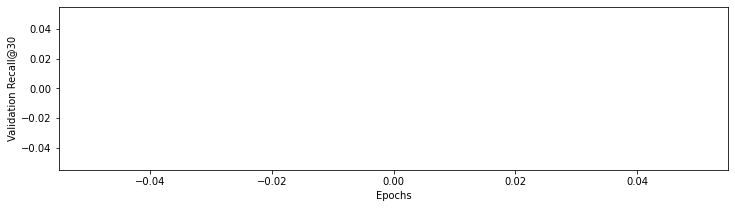

In [ ]:
print_evaluation(rc_vad[:-1], "Recall")

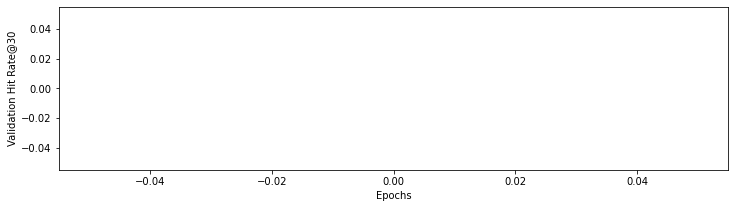

In [ ]:
print_evaluation(hr_vad[:-1], "Hit Rate")

# 2. test

In [17]:
recall, test_hit_rate = ncf.test(test_tr_usr, test_tr_prb, test_tr_entry, test_te_X, test_te_y, cluster=2, batch_size=1024, k=30)
print("recall: ", recall)
print("hit rate: ", test_hit_rate)

recall:  0.1804675279691686
hit rate:  0.701935914552737
